In [3]:
from sqlalchemy import create_engine, Column, Integer, String, Text, Date, ForeignKey
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from datetime import date

# --- Setup Base ---
Base = declarative_base()

# --- Models ---
class User(Base):
    __tablename__ = 'users'
    id = Column(Integer, primary_key=True)
    full_name = Column(String, nullable=False, unique=True)
    role = Column(String)
    team = Column(String)

    daily_updates = relationship("DailyUpdate", back_populates="user")
    assigned_tasks = relationship("Task", back_populates="assigned_to", foreign_keys="Task.assigned_to_id")
    created_tasks = relationship("Task", back_populates="assigned_by", foreign_keys="Task.assigned_by_id")

class DailyUpdate(Base):
    __tablename__ = 'daily_updates'
    id = Column(Integer, primary_key=True)
    user_id = Column(Integer, ForeignKey('users.id'))
    date = Column(Date, nullable=False)
    title = Column(String)
    work_done = Column(Text)
    reference_links = Column(Text)
    comment = Column(Text)

    user = relationship("User", back_populates="daily_updates")

class Task(Base):
    __tablename__ = 'tasks'
    id = Column(Integer, primary_key=True)
    title = Column(String)
    description = Column(Text)
    due_date = Column(Date)
    status = Column(String, default="open")
    assigned_to_id = Column(Integer, ForeignKey('users.id'))
    assigned_by_id = Column(Integer, ForeignKey('users.id'))

    assigned_to = relationship("User", back_populates="assigned_tasks", foreign_keys=[assigned_to_id])
    assigned_by = relationship("User", back_populates="created_tasks", foreign_keys=[assigned_by_id])

# --- Create new database ---
engine = create_engine("sqlite:///employee_task2.db", echo=False)
Base.metadata.create_all(engine)

# --- Bind session ---
Session = sessionmaker(bind=engine)
session = Session()

print("✅ Fresh DB 'employee_task2.db' initialized and session is ready.")

✅ Fresh DB 'employee_task2.db' initialized and session is ready.


In [4]:
# --- USERS ---
manager = User(full_name="Alice Johnson", role="manager", team="Engineering")
employee1 = User(full_name="Sam Wilson", role="employee", team="Engineering")
employee2 = User(full_name="Taylor Smith", role="employee", team="Engineering")

session.add_all([manager, employee1, employee2])
session.commit()

# --- DAILY UPDATES ---
update1 = DailyUpdate(
    user_id=employee1.id,
    date=date(2025, 6, 12),
    title="Security Patch Deployment",
    work_done="Applied critical patches to production systems.",
    reference_links="https://github.com/org/repo/pull/123",
    comment="Need review from security team"
)

update2 = DailyUpdate(
    user_id=employee2.id,
    date=date(2025, 6, 13),
    title="UI Redesign",
    work_done="Completed new dashboard design in Figma.",
    reference_links="https://figma.com/file/xyz",
    comment=None
)

session.add_all([update1, update2])
session.commit()

# --- TASKS ---
task1 = Task(
    title="Optimize DB Queries",
    description="Refactor ORM queries for better performance.",
    due_date=date(2025, 6, 20),
    assigned_by_id=manager.id,
    assigned_to_id=employee1.id
)

task2 = Task(
    title="Update CI/CD Pipeline",
    description="Migrate from Jenkins to GitHub Actions.",
    due_date=date(2025, 6, 22),
    assigned_by_id=manager.id,
    assigned_to_id=employee2.id
)

session.add_all([task1, task2])
session.commit()

print("✅ Dummy data (users, updates, tasks) inserted into employee_task2.db.")


IntegrityError: (sqlite3.IntegrityError) UNIQUE constraint failed: users.full_name
[SQL: INSERT INTO users (full_name, role, team) VALUES (?, ?, ?) RETURNING id]
[parameters: ('Alice Johnson', 'manager', 'Engineering')]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [ ]:
session = Session()
users = session.query(User).all()
for u in users:
    print(f"{u.id} - {u.full_name} ({u.role})")

updates = session.query(DailyUpdate).all()
for upd in updates:
    print(f"{upd.date} - {upd.title} - {upd.work_done}")
session.close()


1 - Alice Johnson (manager)
2 - Sam Wilson (employee)
3 - Taylor Smith (employee)
2025-06-12 - Security Patch Deployment - Applied critical patches to production systems.
2025-06-13 - UI Redesign - Completed new dashboard design in Figma.


In [5]:
from dotenv import load_dotenv
import os
load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                            google_api_key=GEMINI_API_KEY , 
                            temperature=0.7)

e:\Rise_Employee_Management_System\rise_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def llm_call(prompt: str) -> str:
    response = llm.invoke(prompt)
    return response.content

In [8]:
llm_call('What is the weather like in New York?')  # Example call to test the LLM

"The weather in New York City is currently:\n\n*   **Temperature:** 66°F (19°C)\n*   **Condition:** Mostly Cloudy\n*   **Wind:** 13 mph\n\nIt's expected to be mostly cloudy throughout the day, with a high of 71°F (22°C)."

In [9]:
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class AgentState(TypedDict):
    messages: List[BaseMessage]
    query_type: Optional[str]
    retrieved_data: Optional[str]


In [ ]:
from typing import List, Optional, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: List[BaseMessage]                  # Full chat history
    query_type: str                              # "retrieve_updates", "assign_task", "add_comment", etc.
    retrieved_data: Optional[str]                # Final result after processing
    context_employee_name: Optional[str]         # Employee being referred to
    context_task_title: Optional[str]            # Task title if relevant
    context_date: Optional[str]                  # Parsed date or time reference
    session_user_id: Optional[int]               # ID of currently logged-in manager from session


In [ ]:
from app.utils.llm import llm_call
from app.agents.state import AgentState
from datetime import datetime

def classify_query(state: AgentState):
    last_msg = state["messages"][-1].content
    today = datetime.today().date()

    prompt = f"""
You are an intelligent assistant helping route manager queries. From the message below, extract:

1. Query type: One of ["retrieve_updates", "assign_task", "add_comment"]
2. Employee full name (if mentioned)
3. Task title (if mentioned)
4. Due date or relevant date - Today is {today}.Try to extract the date from the text by comparing it with today.
    If no date is provided, use today: {today}.

Message:
"{last_msg}"

Respond in this format (exactly):
Query type: ...
Employee: ...
Task title: ...
Date: ...
"""

    response = llm_call(prompt)
    print("🔍 Parsed metadata:\n", response)

    # Parse response (naive version for now)
    lines = response.strip().splitlines()
    query_type = lines[0].split(":")[1] if len(lines) > 0 else ""
    employee = lines[1].split(":")[1] if len(lines) > 1 else ""
    task_title = lines[2].split(":")[1] if len(lines) > 2 else ""
    date_str = lines[3].split(":")[1] if len(lines) > 3 else ""

    return {
        "query_type": query_type,
        "context_employee_name": employee if employee.lower() != "none" else "",
        "context_task_title": task_title if task_title.lower() != "none" else "",
        "context_date": date_str if date_str.lower() != "none" else "",
        "retrieved_data": "",  # Will be populated later
        "session_user_id": state.get("session_user_id")  # Ensure this flows from initial setup
    }


In [11]:
from datetime import datetime

def retrieve_updates(state: AgentState):
    user_input = state["messages"][-1].content
    today = datetime.today().date()

    # Step 1: Extract employee name and date via LLM
    extraction_prompt = f"""
    Extract the employee's full name and date (in YYYY-MM-DD format) from:
    "{user_input}"
    Today is {today}.Try to extract the date from the text by comparing it with today.
    If no date is provided, use today: {today}.
    Return only the name on the first line, and the date on the second line.
    """
    result = llm_call(extraction_prompt).splitlines()
    emp_name, req_date = result[0].strip(), result[1].strip()

    # Step 2: Query user and updates
    with Session() as session:
        user = session.query(User).filter(User.full_name == emp_name).first()

        if not user:
            return {"retrieved_data": f"No employee found with name: {emp_name}"}

        # Filter DailyUpdate by user ID and date
        updates = session.query(DailyUpdate).filter(
            DailyUpdate.user_id == user.id,
            DailyUpdate.date == req_date
        ).all()

        if not updates:
            return {"retrieved_data": f"No updates found for {emp_name} on {req_date}"}

        # Format updates
        updates_str = "\n".join(
            f"{u.date} - {u.title}: {u.work_done}" for u in updates
        )

    # Step 3: Summarize
    summary_prompt = f"Summarize the following work updates for {emp_name} on {req_date}:\n{updates_str}"
    summary = llm_call(summary_prompt)

    return {
        "retrieved_data": f"Summary for {emp_name} on {req_date}:\n\n{summary}",
        "target_employee": {"id": user.id, "name": user.full_name}
    }


In [27]:
def assign_task(state: AgentState):
    print('Assigning task...')
    user_input = state["messages"][-1].content

    # Prompt LLM to return line-by-line output
    prompt = f"""
From the following task assignment message, extract the following details in order:

1. Full name of the person assigning the task (if not provided, use "Alice Johnson")
2. Full name of the person receiving the task
3. Title of the task
4. Description of the task
5. Due date (format: YYYY-MM-DD)

Only return these 5 items, one per line.

Message: "{user_input}"
"""

    response = llm_call(prompt)
    lines = [line.strip() for line in response.strip().splitlines() if line.strip()]
    
    # Debug print
    print("🔍 Extracted lines:", lines)

    if len(lines) < 5:
        return {"retrieved_data": "❌ Could not extract all required task information. Please rephrase."}

    assigned_by_name, assigned_to_name, title, description, due_date_str = lines[:5]

    # Fallback if assigner not mentioned
    if not assigned_by_name:
        assigned_by_name = "Alice Johnson"

    # Start DB session
    session = Session()

    assigner = session.query(User).filter_by(full_name=assigned_by_name).first()
    assignee = session.query(User).filter_by(full_name=assigned_to_name).first()

    if not assigner or not assignee:
        return {"retrieved_data": f"❌ Could not find assigner or assignee in the system.\nAssigner: {assigned_by_name}, Assignee: {assigned_to_name}"}

    # Create and commit task
    try:
        task = Task(
            title=title,
            description=description,
            due_date=date.fromisoformat(due_date_str),
            assigned_by_id=assigner.id,
            assigned_to_id=assignee.id,
            status="open"
        )
        session.add(task)
        session.commit()
    except Exception as e:
        return {"retrieved_data": f"❌ Failed to save task: {e}"}

    return {
        "retrieved_data": (
            f"✅ Task assigned!\n\n"
            f"• Title: {title}\n"
            f"• Description: {description}\n"
            f"• Assigned by: {assigned_by_name}\n"
            f"• Assigned to: {assigned_to_name}\n"
            f"• Due Date: {due_date_str}"
        )
    }


In [ ]:
def add_comment(state: AgentState):
    print('Adding comment...')
    user_input = state["messages"][-1].content

    # Extract name, date, and comment using LLM
    prompt = f"""
    From the following message, extract:
    1. The full name of the employee
    2. The date of the daily update (YYYY-MM-DD format)
    3. The comment to be added

    Message: "{user_input}"
    
    Respond with:
    Line 1: Full name
    Line 2: Date (YYYY-MM-DD)
    Line 3: Comment text
    """
    lines = llm_call(prompt).splitlines()
    if len(lines) < 3:
        return {"retrieved_data": "❌ Could not parse the name, date, and comment."}

    name, date_str, comment_text = lines[0], lines[1], lines[2]
    
    # Query and update
    session = Session()
    user = session.query(User).filter_by(full_name=name).first()
    if not user:
        return {"retrieved_data": f"❌ No employee found with name: {name}"}

    update = session.query(DailyUpdate).filter_by(user_id=user.id, date=date.fromisoformat(date_str)).first()
    if not update:
        return {"retrieved_data": f"❌ No update found for {name} on {date_str}"}

    update.comment = comment_text
    session.commit()
    return {"retrieved_data": f"✅ Comment added to {name}'s update on {date_str}."}
    

In [28]:
from langgraph.graph import StateGraph, END, START

# Define the graph
graph = StateGraph(AgentState)  # Use StateGraph, not just Graph()

# Add nodes
graph.add_node("classify_query", classify_query)
graph.add_node("retrieve_updates", retrieve_updates)
graph.add_node("assign_task", assign_task)
graph.add_node("add_comment", add_comment)

graph.add_edge(START, "classify_query")


# Routing function
def router(state: AgentState):
    return state["query_type"]

# Add conditional edges (branches)
graph.add_conditional_edges(
    "classify_query",
    lambda state: state["query_type"],  # This should return one of the node names
    {
        "retrieve_updates": "retrieve_updates",
        "assign_task": "assign_task", 
        "add_comment": "add_comment"
    }
)

# Connect tools to END
graph.add_edge("retrieve_updates", END)
graph.add_edge("assign_task", END)
graph.add_edge("add_comment", END)

# Start the graph
graph.add_edge(START, "classify_query")

# Compile it
agent4 = graph.compile()

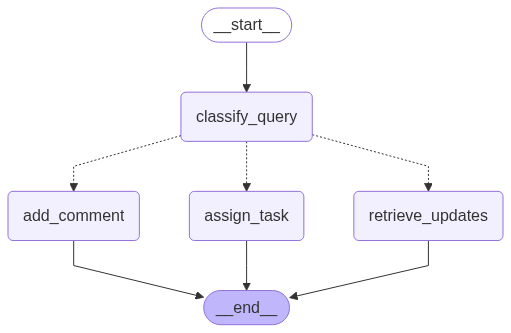

In [21]:
from IPython.display import Image, display

try:
    display(Image(agent4.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import HumanMessage

# Example user input
user_input = "What is the update on Task to Taylor Smith 13th of june?"

# Initial state
initial_state = {
    "messages": [HumanMessage(content=user_input)]
}

In [17]:
# Run the graph with initial state
final_state = agent4.invoke(initial_state)
final_state

{'messages': [HumanMessage(content='What is the update on Task to Taylor Smith 13th of june?', additional_kwargs={}, response_metadata={})],
 'query_type': 'retrieve_updates',
 'retrieved_data': 'Summary for Taylor Smith on 2025-06-13:\n\nOn June 13, 2025, Taylor Smith completed the new dashboard design in Figma for the UI Redesign project.'}

In [29]:
from langchain_core.messages import HumanMessage

# Example user input
user_input = "Assign a new task to Sam Wilson: Optimize the database queries, due on 2025-06-20. Description: Refactor ORM queries for better performance assigned by Alice Johnson."

# Initial state
initial_state = {
    "messages": [HumanMessage(content=user_input)]
}

final_state = agent4.invoke(initial_state)
final_state  

Assigning task...
🔍 Extracted lines: ['Alice Johnson', 'Sam Wilson', 'Optimize the database queries', 'Refactor ORM queries for better performance', '2025-06-20']


{'messages': [HumanMessage(content='Assign a new task to Sam Wilson: Optimize the database queries, due on 2025-06-20. Description: Refactor ORM queries for better performance assigned by Alice Johnson.', additional_kwargs={}, response_metadata={})],
 'query_type': 'assign_task',
 'retrieved_data': '✅ Task assigned!\n\n• Title: Optimize the database queries\n• Description: Refactor ORM queries for better performance\n• Assigned by: Alice Johnson\n• Assigned to: Sam Wilson\n• Due Date: 2025-06-20'}